In [ ]:
#hide
import matplotlib.pyplot as plt
import numpy as np

# qsam - quantum protocol sampling

> Efficient and user-friendly sampling of quantum protocols.

## Install

`pip install qsam`... not yet, soon to come

## Prerequisites 

## When to use

qsam offers efficient and fast estimation of logical failure rates of quantum error correction protocols when the fidelity of physical operations in the quantum circuits is high, such as in expertimental implementations today. 

This package is for you if you want to
* model circuit-level incoherent Pauli noise (we don't do coherent noise here, neither are our auxiliary qubits modelled as ideal) 
* with high fidelity physical operations aka low physical error rates
* for a QEC protocol that consists of execution of one or more quantum circuits with in-sequence measurements and feed-forward of measurement information
* over a specific range of varying physical error rates

It currently offers to
* build quantum circuits from the standard quantum gates: H, X, Z, CNOT
* run stabilizer simulations with a standard CHP backend
* model multiparameter noise with distinct error rates for single- and two-qubit gates: p1, p2
* estimate logical failure rates until uncertainty is lower than a given target confidence interval
* choose direct Monte Carlo or Subset Sampling as sampling method

Background information:

The predominant method to model incoherent Pauli noise in quantum circuits is direct Monte Carlo (MC) sampling. MC is very inefficient for low physical error rates since most of the time no actual fault event is realized in simulation. Subset sampling circumvents this issue. With this method, presented in \cite{DSS}, fault events are categorized into distinct subsets which contribute to a polynomial sum expansion of the logical failure rate. In subset sampling, only the subsets that contribute most to the logical failure rate are actually estimated via sampling -- rendering it an importance sampling technique. Both the sampling variance and the uncertainty from ignored, i.e. non-sampled, subsets stay well-defined and can be held small throughout the sampling procedure.

## Getting started

### Circuits 

To get started, we first need to define one or more circuits, which is easily done in qsam. Below we create a circuit that prepares the 4-qubit GHZ state $|\text{GHZ}\rangle=\frac{1}{\sqrt{2}}(|0000\rangle+|1111\rangle)$. 

In [ ]:
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}], ff_det=True)

The keyword `ff_det`is set to `True` to indicate that the circuit will yield a deterministic outcome when ran fault-free. It is important for the calculation of uncertainties. This need not be the case, e.g. for circuits that measure stabilizers on unencoded states and thus yield random measurement results. An example of a fault-tolerant measurement circuit for the Steane code stabilizer $Z_0Z_1Z_3Z_6$ is given below. The default value of `ff_det`is `False`.

In [ ]:
sz_123 = Circuit([{"init": {8}},
                {"CNOT": {(0,8)}},
                {"CNOT": {(1,8)}},
                {"CNOT": {(3,8)}},
                {"CNOT": {(6,8)}},
                {"measure": {8}}])

In [ ]:
# add ghz run, explain all arguments and comparison of mc and ss

In [ ]:
# also output errors, esp. show that delta only becomes smaller

### Protocols

From the single ghz-circuit given above, we may construct a simple toy-protocol to demonstrate essential features of qsam. The protocol is that, whenever the circuit measurement is $-1$, we shall repeat the preparation circuit since the fifth qubit indicates preparation of an erroneous state. When the measurement is $+1$ the state is prepared correctly. If there is still no $+1$ after two preparation attempts, we count the protocol run as a logical failure. These conditions are defined in the following functions:

In [ ]:
from qsam.protocol import Protocol, draw_protocol

def repeat(m):
    return len(m) < 2 and m[-1] == 1
    
def logErr(m):
    return len(m) >= 2 and m[-1] == 1 and m[-2] == 1

functions = {'logErr': logErr, 'repeat': repeat}

The protocol is now defined as a graph, where nodes are circuits and edges between the nodes are labelled with transition conditions between the circuits. Terminating a protocol with success (instead of fail) will not be shown explicitly by the protocol graph. The `check` argument takes a function, which returns a boolean, to evaluate a transition based on the sequence of measurement results stored in the node as a list (`ghz` in this example).

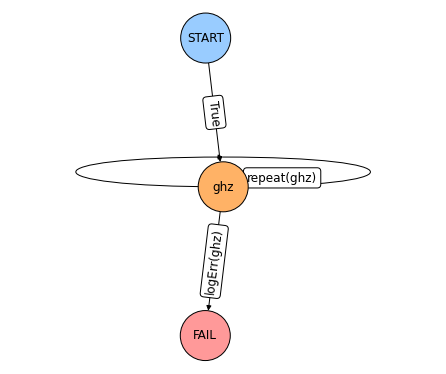

In [ ]:
g = Protocol()
g._check_fns.update(functions)
g.add_nodes_from(['ghz'], circuits=[ghz])

g.add_edge('START', 'ghz', check='True')

g.add_edge('ghz', 'ghz', check='repeat(ghz)')
g.add_edge('ghz', 'FAIL', check='logErr(ghz)')

draw_protocol(g, figsize=(6,5))

We may now specify our error parameters and the range over which we wish to scale the physical error rates. Let's start with a single parameter $p$ for both single- and two-qubit-gates which we set to $p = 0.01$. The scale will enable us to explore logical failure rates resulting from $p \in [0.00001, 0.1]$.

In [ ]:
err_params = {'p': 0.01}
scale = np.logspace(-3,1,5)

We initialize a new direct Monte Carlo sampler and set it up with our error model and scale.

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator
from qsam.samplers.protocol_samplers import Sampler

mc_sam = Sampler(g, ChpSimulator)

mc_sam.setup(scale, err_params)

Its `run` function takes the maximum number of samples and/or a relative target sampling uncertainty as arguments and generates the output defined by the callback functions. Here we specify a maximum error of 10% (which is actually the default value) or 1000 samples at max. The logical failure rate estimator and its uncertainty should be stored and plotted in the range defined by `scale`.

Total:   0%|          | 0/5 [00:00<?, ?it/s]

p_phy=1.00E-05:   0%|          | 0/50000 [00:00<?, ?it/s]

p_phy=1.00E-04:   0%|          | 0/50000 [00:00<?, ?it/s]

p_phy=1.00E-03:   0%|          | 0/50000 [00:00<?, ?it/s]

p_phy=1.00E-02:   0%|          | 0/50000 [00:00<?, ?it/s]

p_phy=1.00E-01:   0%|          | 0/50000 [00:00<?, ?it/s]

Rel. std target of 0.1 reached. Sampling stopped.


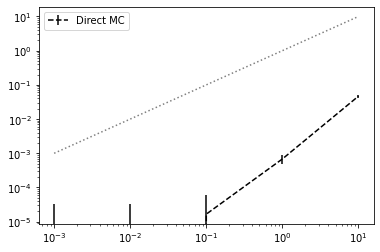

In [ ]:
#slow

import qsam.samplers.callbacks as cb

callbacks = [
    cb.RelStdTarget(target=0.1),
    cb.PlotStats(scale)
]

mc_sam.run(n_samples=50000, callbacks=callbacks)

In [ ]:
# last value not sampled? -> TODO: Investigate why this happens.

The sampler instance allows to print the logical failure rate estimator and its sampling and cutoff error over the sampled range.

In [ ]:
#slow
p_L, std, delta = mc_sam.stats()
print(p_L)
print(std)

[0.         0.         0.         0.0008     0.04682914]
[0.00019201 0.00019201 0.00019201 0.00058627 0.00468174]


We can observe in the statistics of the direct MC Sampler that it does not even record logical failures with moderately low $p$ with the given number of samples. The Subset Sampler fixes this problem. 

Additionally to just sampling the logical failure rate we can specify a variety of callbacks to track desired quantities of the sampling process. A comprehensive list is given in `directory`. Below we plot, for example, the logical failure rate at `p = p_max = 0.01` and its uncertainty as a function of the number of samples run.

Total:   0%|          | 0/1000 [00:00<?, ?it/s]

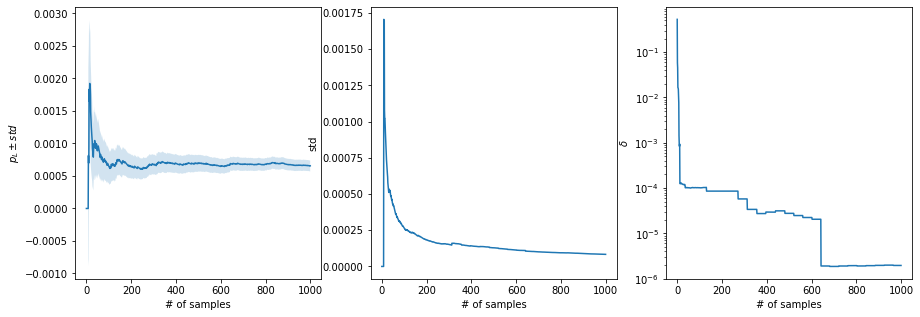

In [ ]:
#slow
from qsam.samplers.protocol_samplers import SubsetSampler

sb_sam = SubsetSampler(g, ChpSimulator)
sb_sam.setup(scale, err_params, p_max=err_params['p'])

callbacks = [
    cb.StatsPerSample()
]
sb_sam.run(1000, callbacks=callbacks)

The Sampler instance contains a `Tree` structure that we can investigate manually with `sb_sam.tree`, or plot as image.

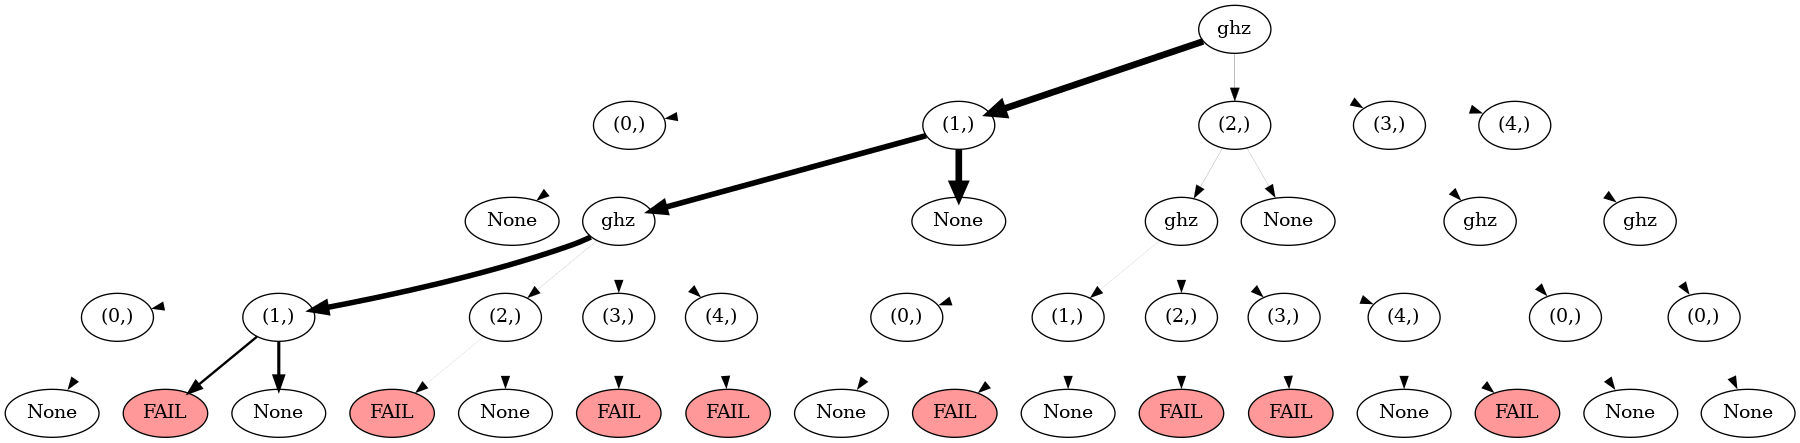

'temp.png'

In [ ]:
#slow
sb_sam.tree.display_tree()

From plotting the MC and SS results together we can see that they produce the same results in some intermediate regime of $p$. Subset Sampling achieves tight bounds on the logical failure rate for low $p$ where the uncertainty for MC is large. Vice versa, Subset Sampling becomes inefficient if the cutoff error from only sampling a few subsets becomes large for larger $p$. Here though, MC is efficient.

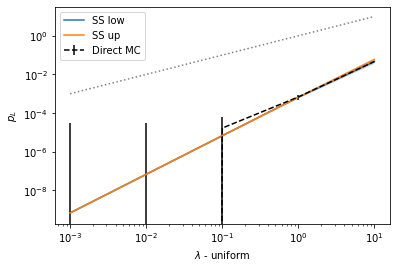

In [ ]:
#slow
import matplotlib.pyplot as plt

p_L_low, ss_std, delta = sb_sam.stats()
p_L, std, _ = mc_sam.stats()

plt.errorbar(scale, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(scale, p_L_low, label="SS low")
plt.fill_between(scale, p_L_low-ss_std, p_L_low+delta+ss_std, alpha=0.2)

plt.plot(scale, p_L_low+delta, label="SS up")
plt.fill_between(scale, p_L_low-ss_std, p_L_low+delta+ss_std, alpha=0.2)

plt.plot(scale, scale, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$p_L$')
plt.xlabel(r'$\lambda$ - uniform')
plt.legend();

With the already sampled subsets we can also vary the plotted range in retrospect. 

In [ ]:
#slow
adjusted_scale = np.logspace(0,1,5)
sb_sam.set_range(adjusted_scale)
p_L_low, delta, v_L = sb_sam.stats()

(Below we also show the MC output in the adjusted range but for the direct Sampler we cannot modify the range in that way)

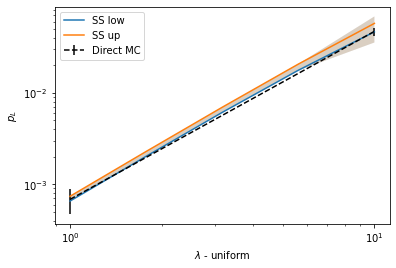

In [ ]:
#slow
plt.errorbar(scale[-2:], p_L[-2:], fmt='--', c="black", yerr=std[-2:], label="Direct MC")

plt.plot(adjusted_scale, p_L_low, label="SS low")
plt.fill_between(adjusted_scale, p_L_low-ss_std, p_L_low+delta+ss_std, alpha=0.2)

plt.plot(adjusted_scale, p_L_low+delta, label="SS up")
plt.fill_between(adjusted_scale, p_L_low-ss_std, p_L_low+delta+ss_std, alpha=0.2)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$p_L$')
plt.xlabel(r'$\lambda$ - uniform')
plt.legend();

We may add 100 more samples to the already existing 500 samples...

Total:   0%|          | 0/100 [00:00<?, ?it/s]

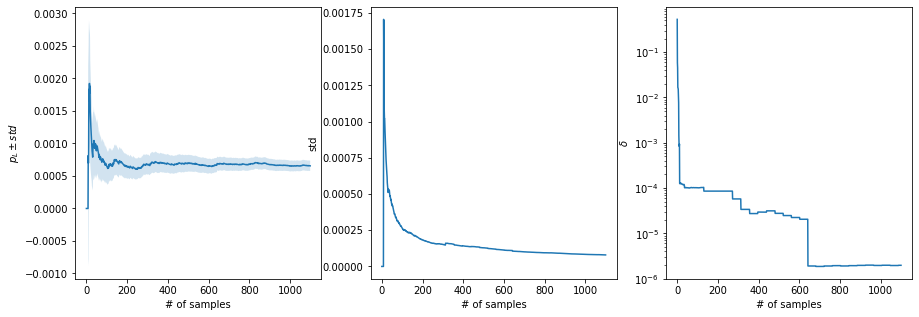

In [ ]:
#slow
sb_sam.run(100, callbacks=callbacks)

... or pickle it for later use.

In [ ]:
#slow
print(sb_sam.tree)

ghz (1100)
├── (0,) (2)
│   └── None (2/2, 1.08e-01)
├── (1,) (1071)
│   ├── ghz (463/1071, 8.77e-04)
│   │   ├── (0,) (2)
│   │   │   └── None (2/2, 1.08e-01)
│   │   ├── (1,) (451)
│   │   │   ├── FAIL (195/451, 2.07e-03)
│   │   │   └── None (256/451, 2.07e-03)
│   │   ├── (2,) (8)
│   │   │   ├── FAIL (6/8, 6.74e-02)
│   │   │   └── None (2/8, 6.74e-02)
│   │   ├── (3,) (1)
│   │   │   └── FAIL (1/1, 1.00e+00)
│   │   └── (4,) (1)
│   │       └── FAIL (1/1, 1.00e+00)
│   └── None (608/1071, 8.77e-04)
├── (2,) (23)
│   ├── ghz (13/23, 3.53e-02)
│   │   ├── (0,) (2)
│   │   │   └── None (2/2, 1.08e-01)
│   │   ├── (1,) (7)
│   │   │   ├── FAIL (3/7, 8.74e-02)
│   │   │   └── None (4/7, 8.74e-02)
│   │   ├── (2,) (1)
│   │   │   └── FAIL (1/1, 1.00e+00)
│   │   ├── (3,) (1)
│   │   │   └── FAIL (1/1, 1.00e+00)
│   │   └── (4,) (2)
│   │       ├── None (1/2, 1.64e-01)
│   │       └── FAIL (1/2, 1.64e-01)
│   └── None (10/23, 3.53e-02)
├── (3,) (2)
│   └── ghz (2/2, 1.08e-01)
│       └─

In [ ]:
#slow
sb_sam.tree.save('ghz_rep.json')

In [ ]:
#slow
sb_sam.tree.load('ghz_rep.json')
print(sb_sam.tree)

ghz (1100)
├── [0] (2)
│   └── None (2/2, 1.08e-01)
├── [1] (1071)
│   ├── ghz (463/1071, 8.77e-04)
│   │   ├── [0] (2)
│   │   │   └── None (2/2, 1.08e-01)
│   │   ├── [1] (451)
│   │   │   ├── FAIL (195/451, 2.07e-03)
│   │   │   └── None (256/451, 2.07e-03)
│   │   ├── [2] (8)
│   │   │   ├── FAIL (6/8, 6.74e-02)
│   │   │   └── None (2/8, 6.74e-02)
│   │   ├── [3] (1)
│   │   │   └── FAIL (1/1, 1.00e+00)
│   │   └── [4] (1)
│   │       └── FAIL (1/1, 1.00e+00)
│   └── None (608/1071, 8.77e-04)
├── [2] (23)
│   ├── ghz (13/23, 3.53e-02)
│   │   ├── [0] (2)
│   │   │   └── None (2/2, 1.08e-01)
│   │   ├── [1] (7)
│   │   │   ├── FAIL (3/7, 8.74e-02)
│   │   │   └── None (4/7, 8.74e-02)
│   │   ├── [2] (1)
│   │   │   └── FAIL (1/1, 1.00e+00)
│   │   ├── [3] (1)
│   │   │   └── FAIL (1/1, 1.00e+00)
│   │   └── [4] (2)
│   │       ├── None (1/2, 1.64e-01)
│   │       └── FAIL (1/2, 1.64e-01)
│   └── None (10/23, 3.53e-02)
├── [3] (2)
│   └── ghz (2/2, 1.08e-01)
│       └── [0] (2)
│   

## Real examples

For more complicated protocols, we might want to receive more feedback from what the sampler is actually doing. Using the `verbose` keyword, we can print the actual circuit sequences realized through out the sampling procedure and watch which intermediate measurement results lead to different circuit branchings. 

To illustrate this, we give the example of first preparing the logical zero state of the Steane code. A flag qubit verifies correct preparation in the first circuit. The second circuit is only run, if the flag is triggered. It restores the correct state in a fault-tolerant way from the state after the first circuit marked as faulty by the flag.

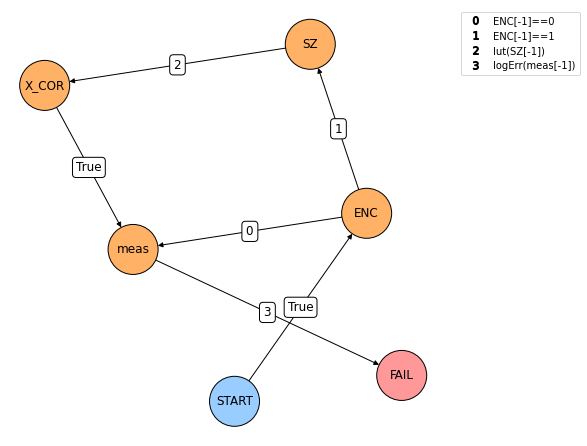

In [ ]:
eft = Circuit([ {"init": {0,1,2,4,3,5,6,7}},
                {"H": {0,1,3}},
                {"CNOT": {(0,4)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(3,5)}},
                {"CNOT": {(0,6)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(1,5)}},
                {"CNOT": {(0,2)}},
                {"CNOT": {(5,6)}},
                {"CNOT": {(4,7)}},
                {"CNOT": {(2,7)}},
                {"CNOT": {(5,7)}},
                {"measure": {7}} ], ff_det=True)

sz_123 = Circuit([{"init": {8}},
                {"CNOT": {(0,8)}},
                {"CNOT": {(1,8)}},
                {"CNOT": {(3,8)}},
                {"CNOT": {(6,8)}},
                {"measure": {8}}])

meas = Circuit([ {"measure": {0,1,2,3,4,5,6}} ])

k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):
    if min([hamming2(out, i) for i in stabilizerSet]) > 1:
        return True
    else:
        return False
        
def flagged_z_look_up_table_1(z):
    if z:
        return Circuit([{'X': {6}}], noisy=False)
    else:
        return Circuit(noisy=False)

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

init = Protocol()
init._check_fns.update(functions)

init.add_nodes_from(['ENC', 'SZ', 'meas'], circuits=[eft, sz_123, meas])
init.add_node('X_COR', circuit=Circuit(noisy=False))

init.add_edge('START', 'ENC', check='True')

init.add_edge('ENC', 'meas', check='ENC[-1]==0')

init.add_edge('ENC', 'SZ', check='ENC[-1]==1')
init.add_edge('SZ', 'X_COR', check='lut(SZ[-1])')

init.add_edge('X_COR', 'meas', check='True')

init.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

draw_protocol(init, figsize=(6,6), edge_legend=True)

The protocol contains a recovery operation which is applied conditioned on the stabilizer measurement result being $-1$. The `check` function, which we previously introduced to only take boolean values, in this case actually accepts a circuit which corresponds to the recovery operation. To avoid also placing fault operators on this circuit, we use the keyword `noisy` and set it to `False` (this can be used for any circuit). The recovery operation is the return value of the look up table function we define above. 

We may choose more realistic error rates for single and two qubit gates.

In [ ]:
err_params = {'p1': 0.01, 'p2': 0.1}

Let's first run 10 samples to see what the protocol does. For this means we can use the `VerboseCircuitExec` callback:

In [ ]:
#slow
sb_sam = SubsetSampler(init, ChpSimulator)
sb_sam.setup(scale, err_params, p_max=(err_params['p1'], err_params['p2']))

callbacks = [
    cb.VerboseCircuitExec()
]
sb_sam.run(10, callbacks=callbacks)

Total:   0%|          | 0/10 [00:00<?, ?it/s]

--- Protocol Run: 1 ---
Node ENC, Faults ["Tick 12 :: {'X': {5}, 'Y': {7}}"], Measured 1-> SZ
Node SZ, Faults [], Measured 0-> None
--- Protocol Run: 2 ---
Node ENC, Faults [], Measured 0-> meas
Node meas, Faults [], Measured 1100110-> None
--- Protocol Run: 3 ---
Node ENC, Faults ["Tick 7 :: {'X': {1}}"], Measured 0-> meas
Node meas, Faults [], Measured 0010011-> None
--- Protocol Run: 4 ---
Node ENC, Faults [], Measured 0-> meas
Node meas, Faults [], Measured 1011010-> None
--- Protocol Run: 5 ---
Node ENC, Faults ["Tick 12 :: {'Z': {7}}", "Tick 10 :: {'Z': {4}, 'Y': {7}}"], Measured 1-> SZ
Node SZ, Faults [], Measured 0-> None
--- Protocol Run: 6 ---
Node ENC, Faults ["Tick 12 :: {'Y': {5, 7}}", "Tick 10 :: {'Y': {4}, 'X': {7}}"], Measured 0-> meas
Node meas, Faults [], Measured 1100000-> FAIL
--- Protocol Run: 7 ---
Node ENC, Faults ["Tick 4 :: {'Z': {3}}", "Tick 10 :: {'Y': {4}}", "Tick 2 :: {'X': {0}, 'Z': {4}}"], Measured 1-> SZ
Node SZ, Faults [], Measured 0-> None
--- Protocol

When the flag is triggered, measurement of $Z_0Z_1Z_3Z_6$ follows. 

We can now go on and sample in a regime virtually inaccessible to direct MC until our target uncertainty of -- let say 5% -- is reached.

In [ ]:
err_params = {'p1': 0.0001, 'p2': 0.001}

Total:   0%|          | 0/10000 [00:00<?, ?it/s]

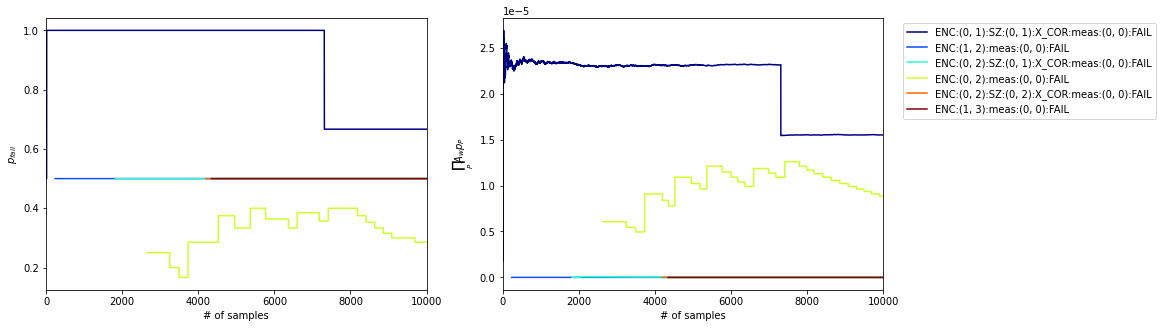

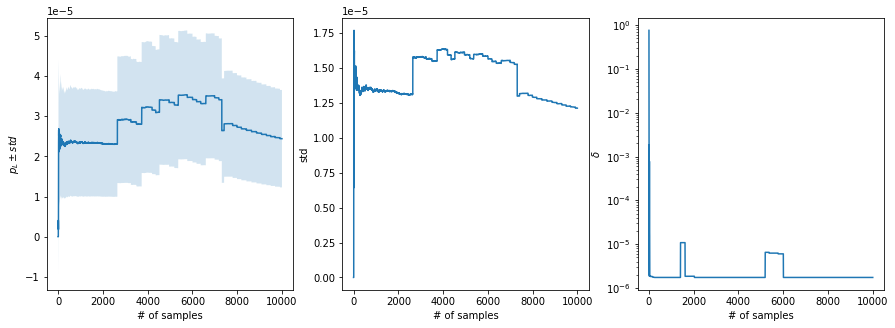

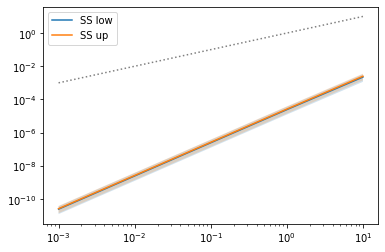

In [ ]:
#slow
sb_sam = SubsetSampler(init, ChpSimulator)
sb_sam.setup(scale, err_params, p_max=(err_params['p1'], err_params['p2']))

callbacks = [
    cb.RelStdTarget(target=0.05),
    cb.SubsetRates(),
    cb.StatsPerSample(),
    cb.PlotStats(scale)
]

sb_sam.run(10_000, callbacks=callbacks)

In [ ]:
#slow
print(sb_sam.tree)

ENC (10000)
├── (0, 0) (2)
│   └── meas (2/2, 1.08e-01)
│       └── (0, 0) (2)
│           └── None (2/2, 1.08e-01)
├── (0, 1) (9687)
│   ├── SZ (5187/9687, 9.86e-05)
│   │   ├── (0, 0) (5180)
│   │   │   ├── None (3572/5180, 1.59e-04)
│   │   │   └── X_COR (1608/5180, 1.59e-04)
│   │   │       └── meas (1608/1608, 1.42e-06)
│   │   │           └── (0, 0) (1608)
│   │   │               └── None (1608/1608, 1.42e-06)
│   │   ├── (0, 1) (3)
│   │   │   └── X_COR (3/3, 7.88e-02)
│   │   │       └── meas (3/3, 7.88e-02)
│   │   │           └── (0, 0) (3)
│   │   │               ├── FAIL (2/3, 1.34e-01)
│   │   │               └── None (1/3, 1.34e-01)
│   │   ├── (0, 2) (2)
│   │   │   └── None (2/2, 1.08e-01)
│   │   └── (0, 3) (2)
│   │       ├── X_COR (1/2, 1.64e-01)
│   │       │   └── meas (1/1, 1.00e+00)
│   │       │       └── (0, 0) (1)
│   │       │           └── None (1/1, 1.00e+00)
│   │       └── None (1/2, 1.64e-01)
│   └── meas (4500/9687, 9.86e-05)
│       └── (0, 0) (4500)
│

More elaborate examples are given in `directory`.

## Contribute 

# planned future features
* statevector backend
* MS gates
* crosstalk and idling noise

# submit your feature request via github issue

## Team 

qsam was developed by Don Winter based on \cite{DSS} and in collaboration with Sascha Heußen under supervision of Prof. Dr. Markus Müller.

## License